<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula08a_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetMulticlasse(n=400, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1), cluster_std=0.07)
  return X, y

X, y = criaDatasetMulticlasse()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

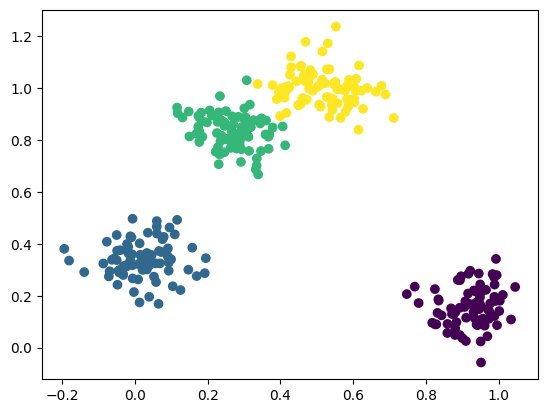

In [2]:
from matplotlib import pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)

plotDataset(X_train, y_train)
plt.show()

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SLPTorch(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=50):
        self.max_iter = max_iter
        self.model = None

    def fit(self, X, y):
        input_shape = X.shape[1]
        self.labels, ids = np.unique(y, return_inverse=True)
        output_shape = len(self.labels)
        y_tensor = torch.tensor(ids, dtype=torch.long)
        self.model = nn.Sequential(
            nn.Linear(input_shape, output_shape),
            nn.Softmax(dim=1)
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        for epoch in range(self.max_iter):
            optimizer.zero_grad()
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self

    def predict_proba(self, X):
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
        return outputs.numpy()

    def predict(self, X):
        ypred = np.argmax(self.predict_proba(X), axis=1)
        return self.labels[ypred]


0.496875


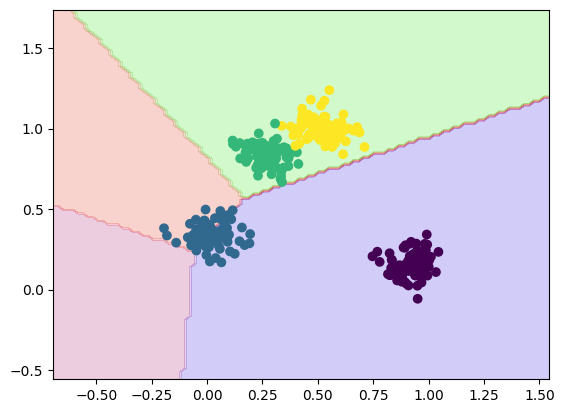

In [6]:
model = SLPTorch()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()


0.25


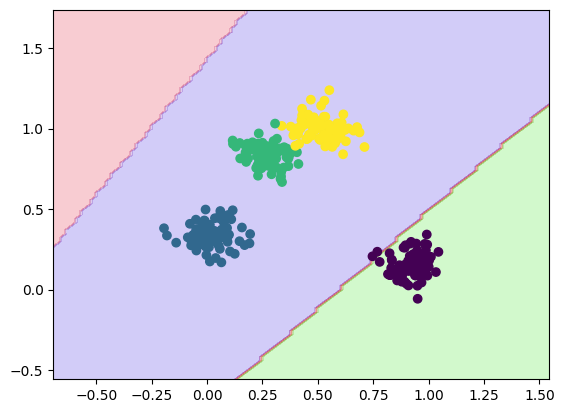

In [7]:
class SHLPTorch(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=50):
        self.max_iter = max_iter
        self.model = None

    def fit(self, X, y):
        input_shape = X.shape[1]
        self.labels, ids = np.unique(y, return_inverse=True)
        output_shape = len(self.labels)
        y_tensor = torch.tensor(ids, dtype=torch.long)
        self.model = nn.Sequential(
            nn.Linear(input_shape, input_shape*2+1),
            nn.ReLU(),
            nn.Linear(input_shape*2+1, output_shape),
            nn.Softmax(dim=1)
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters())
        for epoch in range(self.max_iter):
            optimizer.zero_grad()
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self

    def predict_proba(self, X):
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
        return outputs.numpy()

    def predict(self, X):
        ypred = np.argmax(self.predict_proba(X), axis=1)
        return self.labels[ypred]

model = SHLPTorch()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.53125
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


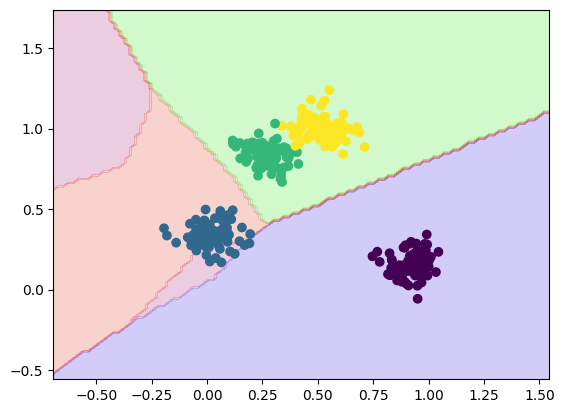

In [8]:
from tensorflow import keras

class SHLPKeras(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=50):
        self.max_iter = max_iter
        self.model = None
    def fit(self, X, y):
        input_shape = X.shape[1]
        output_shape = len(set(y))
        self.labels, ids = np.unique(y, return_inverse=True)
        yhot = keras.utils.to_categorical(ids)
        self.model = keras.Sequential([
            keras.layers.Input(shape=(input_shape,)),
            keras.layers.Dense(input_shape*2+1, activation='relu'),
            keras.layers.Dense(output_shape, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(X, yhot, epochs=self.max_iter, verbose=0)
        return self
    def predict_proba(self, X):
        return self.model.predict(X)
    def predict(self, X):
        ypred = np.argmax(self.predict_proba(X), axis=1)
        return self.labels[ypred]


model = SHLPKeras()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.990625
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


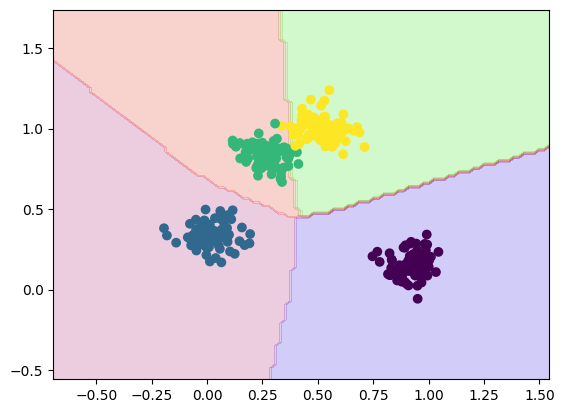

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.9875
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


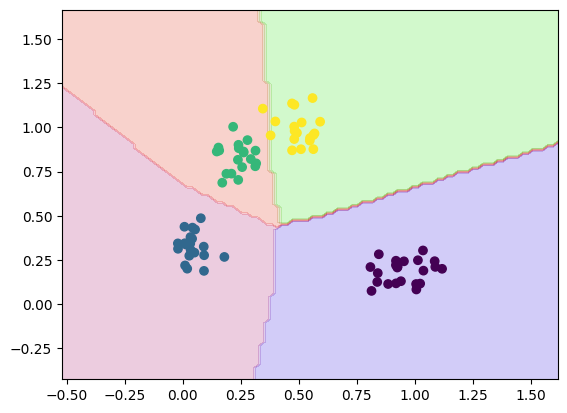

In [9]:
class MLPKeras(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=50, n_hidden=[100]):
        self.max_iter = max_iter
        self.n_hidden = n_hidden
        self.model = None
    def fit(self, X, y):
        input_shape = X.shape[1]
        output_shape = len(set(y))
        self.labels, ids = np.unique(y, return_inverse=True)
        yhot = keras.utils.to_categorical(ids)
        self.model = keras.Sequential()
        self.model.add(keras.layers.Input(shape=(input_shape,)))
        for n in self.n_hidden:
            self.model.add(keras.layers.Dense(n, activation='relu'))
        self.model.add(keras.layers.Dense(output_shape, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(X, yhot, epochs=self.max_iter, verbose=0)
        return self
    def predict_proba(self, X):
        return self.model.predict(X)
    def predict(self, X):
        ypred = np.argmax(self.predict_proba(X), axis=1)
        return self.labels[ypred]

model = MLPKeras()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()

ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plotPredictions(model, X_test)
plotDataset(X_test, y_test)
plt.show()

0.75625


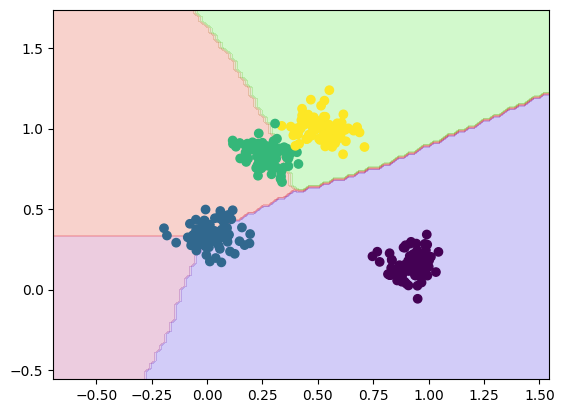

0.7625


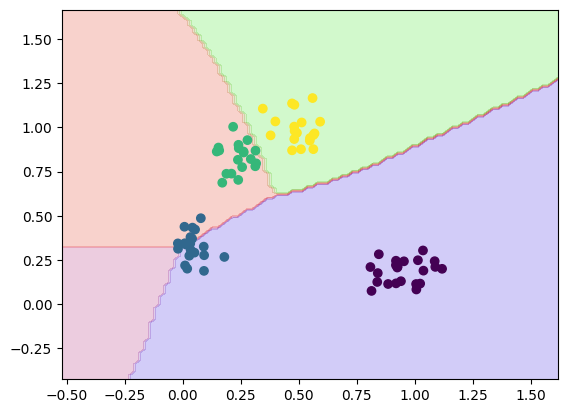

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class MLPPyTorch(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=50, n_hidden=[100]):
        self.max_iter = max_iter
        self.n_hidden = n_hidden
        self.model = None
        self.labels = None

    def fit(self, X, y):
        input_shape = X.shape[1]
        output_shape = len(set(y))

        self.labels, ids = np.unique(y, return_inverse=True)
        yhot = np.eye(output_shape)[ids]  # One-hot encoding

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(yhot, dtype=torch.float32)

        layers = [nn.Linear(input_shape, self.n_hidden[0]), nn.ReLU()]
        for i in range(1, len(self.n_hidden)):
            layers.append(nn.Linear(self.n_hidden[i - 1], self.n_hidden[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.n_hidden[-1], output_shape))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters())

        for _ in range(self.max_iter):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, torch.argmax(y_tensor, axis=1))
            loss.backward()
            optimizer.step()

        return self

    def predict_proba(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            return self.model(X_tensor).numpy()

    def predict(self, X):
        ypred = np.argmax(self.predict_proba(X), axis=1)
        return self.labels[ypred]

# Treinamento e avaliação
model = MLPPyTorch()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()

ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plotPredictions(model, X_test)
plotDataset(X_test, y_test)
plt.show()


0.996875


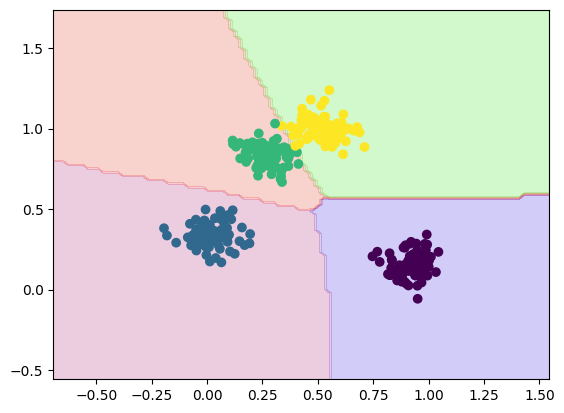

1.0


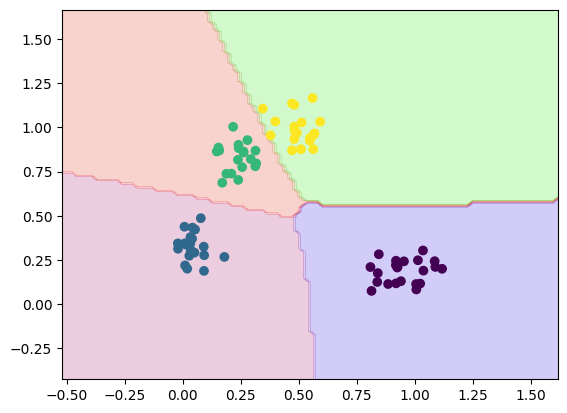

In [14]:
model = MLPPyTorch(max_iter=500, n_hidden=[100])
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()

ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plotPredictions(model, X_test)
plotDataset(X_test, y_test)
plt.show()